In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.optim import lr_scheduler

import torchvision
import torchvision.models as models
import torchvision.datasets as dset
import torchvision.transforms as transforms

from random import *
import os
import cv2
import copy
import time
from PIL import Image

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
#         transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
#         transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

In [3]:
data_dir = "../Data_Set/Resize_Crop_Data_1/"
image_datasets = {x: dset.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [4]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [6]:
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 22)
model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor=0.1, patience=5)

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=8):
    
    global_info = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=11, verbose=True)
    for epoch in range(num_epochs):
        local_info = []
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':

                model.train()
            else:

                model.eval()
                if epoch >0:
                    scheduler.step(val_loss)
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == 'val':
                val_loss = running_loss / dataset_sizes['val']
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                local_info.append(epoch_loss)
                ea = epoch_acc.cpu().numpy()
                local_info.append(ea)
            else:
                local_info.append(epoch_loss)
                ea = epoch_acc.cpu().numpy()
                local_info.append(ea)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        lr_get = get_lr(optimizer)
        print("Current learning rate : {:.8f}".format(lr_get))
        global_info.append(local_info)
        if phase =='val':
            early_stopping(epoch_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [9]:
torch.cuda.empty_cache()
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 2.1138 Acc: 0.4021
val Loss: 1.2323 Acc: 0.6619
Current learning rate : 0.00100000
Validation loss decreased (inf --> 1.232287).  Saving model ...
Epoch 1/99
----------
train Loss: 0.8949 Acc: 0.7569
val Loss: 0.7317 Acc: 0.7836
Current learning rate : 0.00100000
Validation loss decreased (1.232287 --> 0.731673).  Saving model ...
Epoch 2/99
----------
train Loss: 0.5164 Acc: 0.8738
val Loss: 0.5324 Acc: 0.8651
Current learning rate : 0.00100000
Validation loss decreased (0.731673 --> 0.532411).  Saving model ...
Epoch 3/99
----------
train Loss: 0.3660 Acc: 0.9072
val Loss: 0.3760 Acc: 0.9118
Current learning rate : 0.00100000
Validation loss decreased (0.532411 --> 0.375971).  Saving model ...
Epoch 4/99
----------
train Loss: 0.2730 Acc: 0.9251
val Loss: 0.3489 Acc: 0.9222
Current learning rate : 0.00100000
Validation loss decreased (0.375971 --> 0.348916).  Saving model ...
Epoch 5/99
----------
train Loss: 0.2252 Acc: 0.9427
val Loss: 0.5906 Acc: 

val Loss: 0.2494 Acc: 0.9701
Current learning rate : 0.00000100
EarlyStopping counter: 8 out of 11
Epoch 51/99
----------
train Loss: 0.0576 Acc: 0.9867
val Loss: 0.2468 Acc: 0.9717
Current learning rate : 0.00000100
EarlyStopping counter: 9 out of 11
Epoch 52/99
----------
train Loss: 0.0540 Acc: 0.9901
val Loss: 0.2442 Acc: 0.9713
Current learning rate : 0.00000100
EarlyStopping counter: 10 out of 11
Epoch 53/99
----------
train Loss: 0.0585 Acc: 0.9871
val Loss: 0.2468 Acc: 0.9701
Current learning rate : 0.00000100
EarlyStopping counter: 11 out of 11
Early stopping
Training complete in 28m 29s
Best val Acc: 0.972056


In [11]:
torch.save(model, 'lotte_model_resnet18.pt')

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

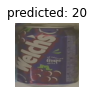

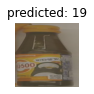

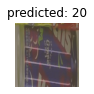

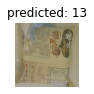

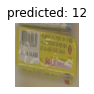

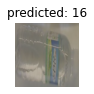

In [13]:
visualize_model(model_ft)

In [14]:
import natsort as nt
from PIL import Image
from torch.autograd import Variable 

def test_model():
    data_transforms = transforms.Compose([
#         transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    model_ft = torch.load('lotte_model_resnet18.pt', map_location=device)
    path_test = "../Data_Set/Resize_Crop_Data_1/test"
    image_list = nt.natsorted(os.listdir(path_test))
    output_list = []
    for i, images in enumerate(image_list):
        path_test_image = os.path.join(path_test, images)
        image = Image.open(path_test_image)
        image = data_transforms(image)
        image.unsqueeze_(dim=0)
        image = Variable(image)
        image = image.cuda(device)
        torch.no_grad()
        output = model_ft(image)
        output = torch.argmax(output, dim=1)
        output_list.append(output)
        
    return output_list

output = test_model()

In [15]:
submission = pd.read_csv('submission.csv')
submission['label'] = torch.cat(output).detach().cpu().numpy()
submission.to_csv('../Data_Set/Resize_Crop_Data_1/submission_resnet18.csv', index=False)

In [16]:
answer = pd.read_csv("../Data_Set/Resize_Crop_Data_1/answer.csv")

In [17]:
cnt = 0
for label1, label2 in zip(submission['label'].values, answer['label'].values):
    if label1 == label2:
        cnt += 1

In [18]:
print(cnt)

404
